In [2]:
%%capture --no-stderr
#%pip install --quiet -U langgraph langchain_anthropic

In [3]:
from dotenv import load_dotenv
load_dotenv('../envls')

import getpass
import os

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

#print(os.environ.get('ANTHROPIC_API_KEY'))
_set_env("ANTHROPIC_API_KEY")

In [4]:
# LangSmith tracing
os.environ["LANGCHAIN_TRACING_V2"] = "true"
_set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_PROJECT"] = "LangGraph Tutorial"

In [5]:
from typing import Literal

from langchain_anthropic import ChatAnthropic
from langchain_core.tools import tool

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import MessagesState, StateGraph, START
from langgraph.prebuilt import ToolNode

# 영속성을 위한 메모리 저장
memory = SqliteSaver.from_conn_string(":memory:")


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return [
        "It's sunny in San Francisco, but you better look out if you're a Gemini 😈."
    ]


tools = [search]
tool_node = ToolNode(tools)
model = ChatAnthropic(model_name="claude-3-haiku-20240307")
bound_model = model.bind_tools(tools)


def should_continue(state: MessagesState) -> Literal["action", "__end__"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "__end__"
    # Otherwise if there is, we continue
    return "action"


# Define the function that calls the model
def call_model(state: MessagesState):
    response = model.invoke(state["messages"])
    # We return a list, because this will get added to the existing list
    return {"messages": response}


# Define a new graph
workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory)

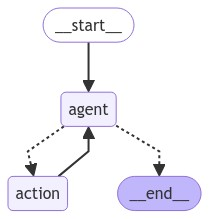

In [6]:
# 랭그래프 클라우드를 사용하면 자동으로 checkpointer가 적용됨
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [7]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "42"}}
input_message = HumanMessage(content="hi! I'm bob")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()


input_message = HumanMessage(content="what's my name?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

hi! I'm bob
================================== Ai Message ==================================

Hello Bob! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

what's my name?
================================== Ai Message ==================================

You told me your name is Bob, so that is the name I have for you.


In [9]:
# 현재 메시지를 확인
messages = app.get_state(config).values['messages']
messages

[HumanMessage(content="hi! I'm bob", id='9b7f68a6-5efe-4ba0-b303-96d78c66135b'),
 AIMessage(content="Hello Bob! It's nice to meet you. How can I assist you today?", response_metadata={'id': 'msg_01Kkzc5GHeAzazCES1Q5LoyE', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 12, 'output_tokens': 20}}, id='run-acd658a8-ad7c-4e4a-a310-2d58f51b8f72-0', usage_metadata={'input_tokens': 12, 'output_tokens': 20, 'total_tokens': 32}),
 HumanMessage(content="what's my name?", id='19ed5dc1-8270-4b09-83cf-5e9a9968b58c'),
 AIMessage(content='You told me your name is Bob, so that is the name I have for you.', response_metadata={'id': 'msg_01JFscWoacuR5aL7pPqQkGF2', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 40, 'output_tokens': 21}}, id='run-db61ed34-1799-4415-91d5-f785c3402b10-0', usage_metadata={'input_tokens': 40, 'output_tokens': 21, 'total_tokens': 61})]

In [10]:
# update_state로 삭제할 수 있음
from langchain_core.messages import RemoveMessage
app.update_state(config, {"messages": RemoveMessage(id=messages[0].id)})

/home/jurepi/.pyenv/versions/langserve/lib/python3.11/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


{'configurable': {'thread_id': '42',
  'thread_ts': '1ef4433f-c60c-6cf1-8005-fbd74f7a2412'}}

In [11]:
# 현재 메시지를 확인
messages = app.get_state(config).values['messages']
messages

[AIMessage(content="Hello Bob! It's nice to meet you. How can I assist you today?", response_metadata={'id': 'msg_01Kkzc5GHeAzazCES1Q5LoyE', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 12, 'output_tokens': 20}}, id='run-acd658a8-ad7c-4e4a-a310-2d58f51b8f72-0', usage_metadata={'input_tokens': 12, 'output_tokens': 20, 'total_tokens': 32}),
 HumanMessage(content="what's my name?", id='19ed5dc1-8270-4b09-83cf-5e9a9968b58c'),
 AIMessage(content='You told me your name is Bob, so that is the name I have for you.', response_metadata={'id': 'msg_01JFscWoacuR5aL7pPqQkGF2', 'model': 'claude-3-haiku-20240307', 'stop_reason': 'end_turn', 'stop_sequence': None, 'usage': {'input_tokens': 40, 'output_tokens': 21}}, id='run-db61ed34-1799-4415-91d5-f785c3402b10-0', usage_metadata={'input_tokens': 40, 'output_tokens': 21, 'total_tokens': 61})]

In [14]:
# 프로그래밍 방식으로 삭제
from langchain_core.messages import RemoveMessage
from langgraph.graph import END

def delete_messages(state):
    messages = state['messages']
    if len(messages) > 3:
        return {"messages": [RemoveMessage(id=m.id) for m in messages[:-3]]}

# We need to modify the logic to call delete_messages rather than end right away
def should_continue(state: MessagesState) -> Literal["action", "delete_messages"]:
    """Return the next node to execute."""
    last_message = state["messages"][-1]
    # If there is no function call, then we call our delete_messages function
    if not last_message.tool_calls:
        return "delete_messages"
    # Otherwise if there is, we continue
    return "action"


# Define a new graph
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)

# This is our new node we're defining
workflow.add_node(delete_messages)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue,)
workflow.add_edge("action", "agent")

# This is the new edge we're adding: after we delete messages, we finish
workflow.add_edge("delete_messages", END)
app = workflow.compile(checkpointer=memory)

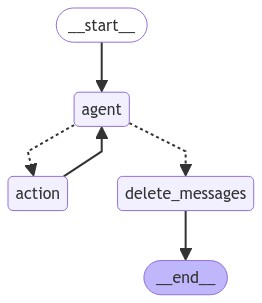

In [15]:
# 랭그래프 클라우드를 사용하면 자동으로 checkpointer가 적용됨
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [16]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="hi! I'm bob")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

input_message = HumanMessage(content="what's my name?")
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    print([(message.type, message.content) for message in event["messages"]])

[('human', "hi! I'm bob")]
[('human', "hi! I'm bob"), ('ai', "It's nice to meet you Bob! I'm Claude, an AI assistant created by Anthropic. How can I help you today?")]
[('human', "hi! I'm bob"), ('ai', "It's nice to meet you Bob! I'm Claude, an AI assistant created by Anthropic. How can I help you today?"), ('human', "what's my name?")]
[('human', "hi! I'm bob"), ('ai', "It's nice to meet you Bob! I'm Claude, an AI assistant created by Anthropic. How can I help you today?"), ('human', "what's my name?"), ('ai', 'You said your name is Bob, so that is the name I will call you.')]
[('ai', "It's nice to meet you Bob! I'm Claude, an AI assistant created by Anthropic. How can I help you today?"), ('human', "what's my name?"), ('ai', 'You said your name is Bob, so that is the name I will call you.')]


In [17]:
input_message

HumanMessage(content="what's my name?", id='bf4f9718-a734-41a4-9517-7294bd17622b')